In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from scipy.spatial.distance import cdist
import math

configuration = tflscripts.read_configuration()

In [2]:
def average_values(df, window_size=5):
    history = []
    averaged_df = []
    std_df = []
    for row in df.values:
        if len(history) > 0:
            averaged_df.append(np.mean(history, axis=0))
            std_df.append(np.std(history, axis=0))
        else:
            averaged_df.append(np.array([0 for _ in row]))
            std_df.append(np.array([0 for _ in row]))

        history.append(row)
        if len(history) > window_size:
            history.pop(0)

    averaged_df = pd.DataFrame(averaged_df)
    averaged_df.columns = df.columns
    averaged_df.index = df.index
    
    std_df = pd.DataFrame(std_df)
    std_df.columns = df.columns
    std_df.index = df.index
    
    return averaged_df, std_df

In [19]:
device = '128.237.248.186'
dataset = 'synergy-final-iter2'

dataset_path = '../datasets/' + dataset + '-complete/'
df = pd.read_pickle(dataset_path + device + '.p')

sensor_channels = [
    'ACCEL_fft',
    'ACCEL_sst',
    'MICROPHONE_sst',
    'MICROPHONE_fft',
    'GEYE',
    'EMI',
    'BAROMETER',
    'TEMPERATURE',
    'HUMIDITY',
]

value_columns = df.filter(regex='|'.join(sensor_channels)).columns

In [20]:
averages, deviations = average_values(df[value_columns], 5)

In [21]:
anomalies = (df[value_columns] - averages) / deviations
anomalies = anomalies.replace([np.inf, -np.inf, np.nan], 0.0)

In [22]:
anomalies_by_channel = {}
for channel in sensor_channels:
    summed = (anomalies.filter(regex=channel) ** 2).sum(axis=1).apply(np.sqrt)
    anomalies_by_channel[channel] = summed

anomalies_by_channel = pd.DataFrame(anomalies_by_channel)

In [23]:
a = (anomalies_by_channel - anomalies_by_channel.min())
columns = a.columns
a['label'] = [configuration['activities'][int(i)] for i in df.label.values]
a = a.reset_index(drop=True)
a.label.unique()

array(['Null', 'Microwave', 'Kettle', 'Chopping food', 'Coffee', 'Dishes',
       'Making popcorn in microwave', 'Conversation', 'Phone ringing',
       'Eating popcorn', 'Faucet', 'Frequency sweep', 'Phone vibrating',
       'Microwave door opened', 'Microwave door closed',
       'Microwave button press', 'Taking ice', 'Room lights off',
       'Knocking'], dtype=object)

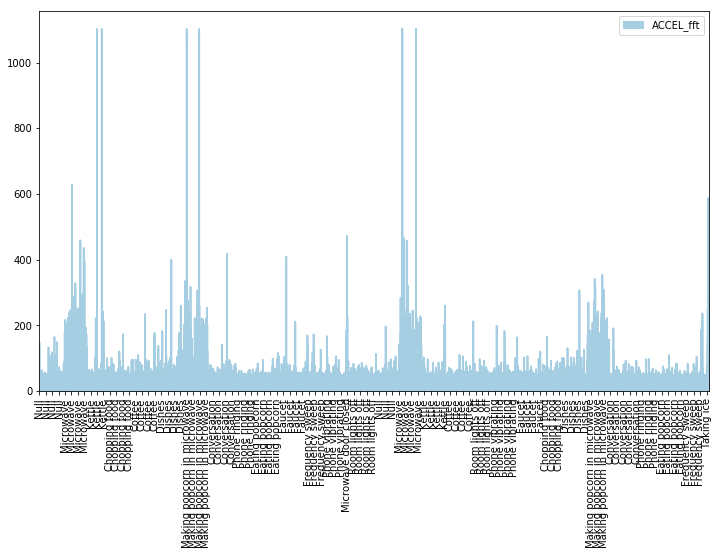

In [30]:
# aa = a.loc[a.label.isin(['Coffee', 'Dishes', 'Making popcorn in microwave'])]
columns = [
    'ACCEL_fft'
]
mean = a[columns].mean()
std = a[columns].std()
aa = a
aa = a[columns].clip(mean - 5 * std, mean + 5 * std, axis=1)
aa[columns].plot.area(colormap='Paired')
labels = a.label
plt.xticks(np.arange(0.5, len(labels), 500), labels[::500], rotation='vertical')
# plt.title(test_labels[k])
# plt.ylim([0, 70])
plt.show()